In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#nlp
import nltk
import string 
import re
from gensim.models import KeyedVectors
from gensim.corpora import Dictionary

#sklearn packages
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
from sklearn.svm import SVR

#utils
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe


#trees
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

In [2]:
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords 

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jeromecohen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jeromecohen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


We used Google Collab (free GPU hours) to run a hyperparameter optimization once we found our best performing models. Uncomment code and have the training_set.csv and holdout_set.csv in the proper path to recreate. 

In [3]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# gdrive = '/content/gdrive/My Drive/Colab Notebooks/'

gdrive = ''
training_df = pd.read_csv(gdrive + 'training_set.csv', encoding='ISO-8859-1')
holdout_df = pd.read_csv(gdrive + 'holdout_set.csv', encoding='ISO-8859-1')

In [4]:

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# EDA 

In [5]:
training_df.head(10)

,Engagements,Followers at Posting,Created,Type,Description
0,502093,36984682,2019-05-21 23:30:51 EDT,Video,The @raptors bench trio of @sergeibaka @norman...
1,603380,36984682,2019-05-21 22:53:33 EDT,Video,@kyle_lowry7 pulls from deep for the @raptors ...
2,603380,36984682,2019-05-21 22:19:58 EDT,Video,@k_mid22 with some english on the @bucks dime!
3,725100,36984682,2019-05-21 22:02:41 EDT,Video,Kawhi punches it home with the left on TNT!
4,661446,36984682,2019-05-21 20:47:49 EDT,Video,@giannis_an34 goes baseline early to rock the ...
5,322444,36955156,2019-05-21 14:02:32 EDT,Photo,Congrats to the 2018-19 NBA All-Rookie First T...
6,722540,36955156,2019-05-21 12:30:53 EDT,Video,The @warriors locked in for four games to adva...
7,339265,36955156,2019-05-21 08:59:02 EDT,Photo,Will the @bucks take a commanding 3-1 lead... ...
8,443330,36955156,2019-05-21 00:48:16 EDT,Photo,TAP to SHOP the @warriors Western Conference C...
9,652193,36955156,2019-05-21 00:38:18 EDT,Video,Hey @stephencurry30... that was the first time...


In [6]:
training_df.dtypes

Engagements              int64
Followers at Posting     int64
Created                 object
Type                    object
Description             object
dtype: object

In [7]:
training_df.describe()

,Engagements,Followers at Posting
count,7.766000e+03,7.766000e+03
mean,5.923129e+05,3.042770e+07
std,1.792682e+05,3.748957e+06
min,1.278160e+05,2.487554e+07
25%,4.173900e+05,2.698910e+07
50%,6.397285e+05,3.004747e+07
75%,7.216282e+05,3.392854e+07
max,1.129585e+06,3.698468e+07


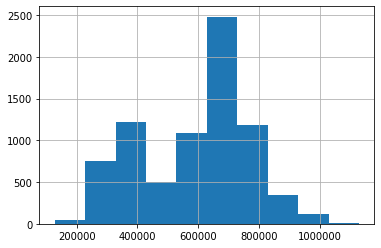

In [8]:
training_df['Engagements'].hist()

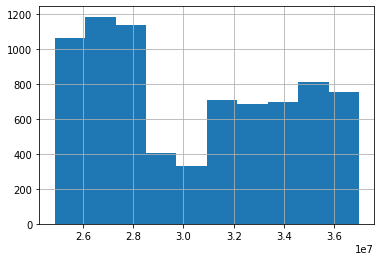

In [9]:
training_df['Followers at Posting'].hist()

-0.05303107729361799


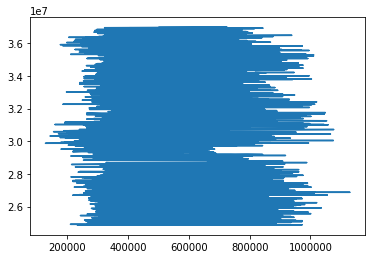

In [10]:
x, y = training_df['Engagements'], training_df['Followers at Posting']
print(x.corr(y))
plt.plot(x, y)
plt.show()

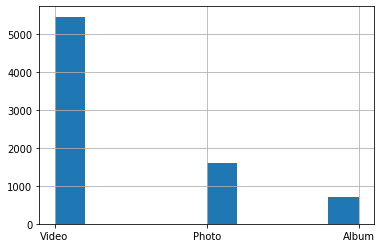

In [11]:
training_df['Type'].hist()

Videos seem to have substanially higher engagement.

In [12]:
type_df = training_df.groupby('Type').mean().reset_index()
type_df

,Type,Engagements,Followers at Posting
0,Album,348465.339411,3.081558e+07
1,Photo,357547.363636,3.055114e+07
2,Video,692773.575669,3.034095e+07


## Seasonality and Time Dependence 

Change columns to datetime 

In [13]:
training_df['Created'] = pd.to_datetime(training_df['Created'])
holdout_df['Created'] = pd.to_datetime(holdout_df['Created'])

In [14]:
year_df = training_df.groupby(training_df['Created'].dt.year).mean().reset_index()
month_df = training_df.groupby(training_df['Created'].dt.month).mean().reset_index()
day_df = training_df.groupby(training_df['Created'].dt.day).mean().reset_index()
dayofweek_df = training_df.groupby(training_df['Created'].dt.dayofweek).mean().reset_index()

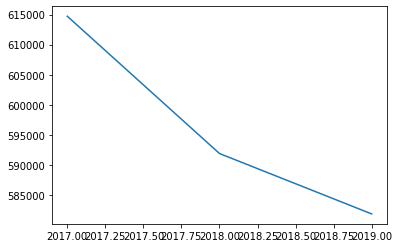

In [15]:
x, y = year_df['Created'], year_df['Engagements']
plt.plot(x, y)
plt.show()

Below we see large seasonality, most of which can be attributed to the NBA season / offseason. 

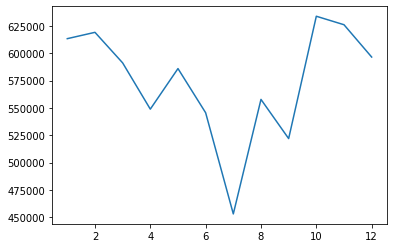

In [16]:
x, y = month_df['Created'], month_df['Engagements']
plt.plot(x, y)
plt.show()

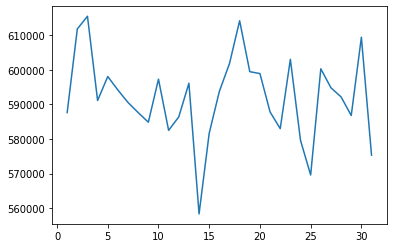

In [17]:
x, y = day_df['Created'], day_df['Engagements']
plt.plot(x, y)
plt.show()

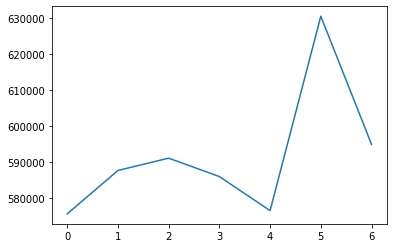

In [18]:
x, y = dayofweek_df['Created'], dayofweek_df['Engagements']
plt.plot(x, y)
plt.show()

We see a decline in engagement as time goes on in the yearly aggregate, though we do not know what to attribute this decline to. More interestingly, we see that July is a low point for engagement (most likely due to the offseason). Twitter activity may be larger then. Additionally, Wednesday - often having many games - see the largest engagement of week days. However, Saturdays have the largest engagement by far. Now let us look at the effect of time on engagement.

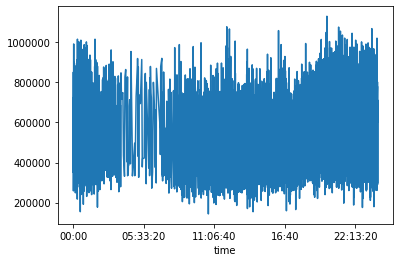

In [19]:
training_df['Time'] = training_df['Created'].dt.time
time_df = training_df.groupby('Time').mean().reset_index() 
x, y = time_df['Time'], time_df['Engagements']
plt.plot(x, y)
plt.show()

The above graph is hard to interpret. Let us magnify in. We may also hypothesize that day of week has an effect on the effectiveness of a specific time for engagements. For example, weekday NBA games are at night but Sunday games can be in the early afternoon.

# Cleaning

Simple cleaning: we drop null values

In [20]:
training_df.dropna(inplace=True)
holdout_df.dropna(subset=['Followers at Posting', 'Created', 'Type', 'Description'], inplace=True) 

We will now clean the descriptions for downstream tasks. This includes removing special characters and stopwords as well as tokenizing the descriptions 

In [21]:
def clean_desription(x): 
    english_stopwords = stopwords.words('english')
    tokenizer = TweetTokenizer(preserve_case=False)
    
    #remove hashtags
    x = re.sub(r'#', '', x)
    
    #remove mentions
    x = re.sub(r'@', '', x)
    
    tokenized = tokenizer.tokenize(x)
    description = []
    for token in tokenized: 
        if (token not in english_stopwords) and (token not in string.punctuation): 
            description.append(token)
            
    
    return description

In [22]:
training_df['description_clean'] = training_df['Description'].apply(lambda x : clean_desription(x))
holdout_df['description_clean'] = holdout_df['Description'].apply(lambda x : clean_desription(x))

# Feature Engineering

First, we count the number of mentions and hashtags to create simple numeric features. Then, we split the timestamp into four features and apply cyclical transformations where appropiate. Then, we one-hot encode categorical variables so that they can be fed into our models. Lastly, we will create word embedding vectors from the description text. 

## Getting Simple Numeric Features from Descriptions
It would be interesting to explore if the number of followers of those mentioned in the descriptions has an effect on engagement. However, for now we will assume all mentions are equal. Addtionally, the popularity of the hashtag most likely has an effect on engagement. However, we will not pull in outside data. 

In [23]:
def count_mentions(description): 
    count = 0
  
    for d in description: 
        if d == '@': 
            count = count + 1
    return count

def count_hashtags(description): 
    count = 0
  
    for d in description: 
        if d == '#': 
            count = count + 1
    return count

In [24]:
training_df['Mentions'] = training_df['Description'].apply(lambda x : count_mentions(x))
training_df['Hashtags'] = training_df['Description'].apply(lambda x : count_hashtags(x))

holdout_df['Mentions'] = holdout_df['Description'].apply(lambda x : count_mentions(x))
holdout_df['Hashtags'] = holdout_df['Description'].apply(lambda x : count_hashtags(x))

## Categorical Encoding 

In [25]:
onehot_df = pd.get_dummies(training_df['Type'])
training_df = pd.concat([training_df, onehot_df], axis=1)

onehot_df = pd.get_dummies(holdout_df['Type'])
holdout_df = pd.concat([holdout_df, onehot_df], axis=1)

## Time Encoding

In [26]:
#Create Features from timestamps

#training
training_df['Month'] = training_df['Created'].dt.month
training_df['DayOfWeek'] = training_df['Created'].dt.dayofweek

#holdout
holdout_df['Month'] = holdout_df['Created'].dt.month
holdout_df['DayOfWeek'] = holdout_df['Created'].dt.dayofweek

To capture the cyclical nature of hours, months, etc we will apply a sin / cos transformation on these features

In [27]:
#training
training_df['hr_sin'] = np.sin(training_df['Created'].dt.hour*(2.*np.pi/24))
training_df['hr_cos'] = np.cos(training_df['Created'].dt.hour*(2.*np.pi/24))
training_df['dow_sin'] = np.sin(training_df['DayOfWeek']*(2.*np.pi/7))
training_df['dow_cos'] = np.cos(training_df['DayOfWeek']*(2.*np.pi/7))
training_df['mnth_sin'] = np.sin((training_df['Month']-1)*(2.*np.pi/12))
training_df['mnth_cos'] = np.cos((training_df['Month']-1)*(2.*np.pi/12))
training_df['day_sin'] = np.sin((training_df['Created'].dt.day)*(2.*np.pi/31)) 
training_df['day_cos'] = np.cos((training_df['Created'].dt.day)*(2.*np.pi/31))

#holdout
holdout_df['hr_sin'] = np.sin(holdout_df['Created'].dt.hour*(2.*np.pi/24))
holdout_df['hr_cos'] = np.cos(holdout_df['Created'].dt.hour*(2.*np.pi/24))
holdout_df['dow_sin'] = np.sin(holdout_df['DayOfWeek']*(2.*np.pi/7))
holdout_df['dow_cos'] = np.cos(holdout_df['DayOfWeek']*(2.*np.pi/7))
holdout_df['mnth_sin'] = np.sin((holdout_df['Month']-1)*(2.*np.pi/12))
holdout_df['mnth_cos'] = np.cos((holdout_df['Month']-1)*(2.*np.pi/12))
holdout_df['day_sin'] = np.sin((holdout_df['Created'].dt.day)*(2.*np.pi/31)) 
holdout_df['day_cos'] = np.cos((holdout_df['Created'].dt.day)*(2.*np.pi/31))

In [28]:
training_df['Year'] = training_df['Created'].dt.year - 2017
holdout_df['Year'] = holdout_df['Created'].dt.year - 2017

## Word Embeddings

### Helper Functions 

In [29]:
def count_words(gsdict, gsbow):
    counts = np.zeros(len(gsdict))
    for doc in gsbow: 
        for word in doc: 
            counts[word[0]] += word[1]
    return counts.tolist() 

In [30]:
def densify(sparse, columns):
    matrix = np.zeros((len(sparse), columns))
    t = 0
    for title in sparse: 
        for word in title: 
            matrix[t, word[0]] = word[1]
        t = t + 1
    return matrix 

In [31]:
def word_context(gsdict, gscorpus, window):
    matrix = np.zeros((len(gsdict), len(gsdict)))
    for title in gscorpus: 
        for w in range(len(title)): 
            index = gsdict.doc2idx([title[w]])
            min_index = max(0, w - window)
            max_index = min(w + window + 1, len(title))
            for context in range(min_index, max_index): 
                if context != w: 
                    context_index = gsdict.doc2idx([title[context]])
                    matrix[index, context_index] += 1
    return sparsify(matrix)

In [32]:
def sparsify(matrix): 
    words = np.empty(matrix.shape[0], dtype=object)
    for word in range(matrix.shape[0]): 
        tuples = []
        for context in range(matrix.shape[1]): 
            count = matrix[word, context]
            if count != 0: 
                t = context, matrix[word, context]
                tuples.append(t)
        words[word] = tuples           
    return words

In [33]:
def sppmi(gswc, counts, logk): 
    length = len(gswc)
    matrix = np.zeros(length, dtype=object)
    w = 0
    for word in gswc: 
        toAdd = []
        for content in word: 
            log = np.log((content[1] * sum(counts)) / (counts[w] * counts[content[0]]))
            sspmi = max(log - logk, 0)
            new_tuple = content[0], sspmi
            toAdd.append(new_tuple)
        matrix[w] = toAdd
        w += 1
    return matrix     

In [34]:
def vec2doc(gsbow, vectors):
    matrix = np.zeros((len(gsbow), vectors.shape[1]), dtype=object)
    i = 0
    for doc in gsbow: 
        vector = np.zeros(vectors.shape[1])
        for word in doc:
            index = word[0]
            count = word[1]
            vector = vector + (count * vectors[index])
        matrix[i] = vector
        i += 1 
    return matrix    

### SPPMI Word-Content Matrix

In [35]:
def get_sppmi(descriptions): 
    desc_dict = Dictionary(descriptions)
    desc_bow = [desc_dict.doc2bow(desc) for desc in descriptions]
    desc_counts = count_words(desc_dict, desc_bow)
    desc_wc = word_context(desc_dict, descriptions, 2)
    desc_sppmi = sppmi(desc_wc, desc_counts, 0)
    desc_dense_sppmi = densify(desc_sppmi, len(desc_dict)) 
    return vec2doc(desc_bow, desc_dense_sppmi)

In [36]:
descriptions = pd.concat([training_df['description_clean'], holdout_df['description_clean']])
mid = len(training_df['description_clean'])
all_sppmi = get_sppmi(descriptions)

vecs_sppmi = all_sppmi[:mid]
vecs_holdout_sppmi = all_sppmi[mid:]

assert (len(vecs_sppmi) == len(training_df))
assert (len(vecs_holdout_sppmi) == len(holdout_df))

# Models
## Regression

We start of with simple linear regression as a baseline. Let us create a simple model before brining in our generated features.

In [37]:
X = np.array(training_df[['Followers at Posting', 'Album', 'Video', 'Photo']])
y = np.array(training_df['Engagements'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = LinearRegression().fit(X_train, y_train)
print(model.score(X_test, y_test))
print(model.coef_)
print(model.intercept_)
print(mean_absolute_percentage_error(y_test, model.predict(X_test)))

0.7329874110859584
[-1.02450794e-03 -1.16699593e+05  2.26181965e+05 -1.09482372e+05]
498405.3704118179
12.944134105523682


In [38]:
X = np.array(training_df['Followers at Posting']).reshape(-1, 1)
y = np.array(training_df['Engagements']).reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = LinearRegression().fit(X_train, y_train)
print(model.score(X_test, y_test))
print(model.coef_)
print(model.intercept_)
print(mean_absolute_percentage_error(y_test, model.predict(X_test)))

0.002418020305444024
[[-0.00251557]]
[667849.3232951]
32.601401095659696


### Regression with Description Metadata + Time

In [39]:
X = np.array(training_df[['Followers at Posting', 'Album', 'Video', 'Photo', 'Mentions', 'Hashtags']])
y = np.array(training_df['Engagements'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = LinearRegression().fit(X_train, y_train)
print(model.score(X_test, y_test))
print(model.coef_)
print(model.intercept_)
print(mean_absolute_percentage_error(y_test, model.predict(X_test)))

0.7955467717065124
[-2.00652975e-04 -1.25077229e+05  2.33634626e+05 -1.08557396e+05
 -3.83493727e+04 -6.39553769e+03]
530096.4989895321
10.560346087703982


We add in time as feature 

In [40]:
X2 = np.array(training_df[['Followers at Posting', 'Album', 'Video', 'Photo', 'Mentions', 'Hashtags', 'dow_sin',
                          'dow_cos', 'mnth_cos', 'mnth_sin']])
y2 = np.array(training_df['Engagements'])

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2)

model = LinearRegression().fit(X2_train, y2_train)
print(model.score(X2_test, y2_test))
print(model.coef_)
print(model.intercept_)
print(mean_absolute_percentage_error(y2_test, model.predict(X2_test)))

0.8205659678428736
[ 8.59855433e-05 -1.27293781e+05  2.33062770e+05 -1.05768990e+05
 -3.88553592e+04 -1.79656192e+03 -1.67281001e+04  2.09515684e+03
  1.91571565e+04 -7.32237583e+03]
513843.759132812
10.167134533770277


In [41]:
X3 = np.array(training_df[['Followers at Posting', 'Album', 'Video', 'Photo', 'Mentions', 'Hashtags', 'dow_sin',
                          'dow_cos', 'mnth_cos', 'mnth_sin', 'hr_sin', 'hr_cos', 'day_cos', 'day_sin', 'Year']])
y3 = np.array(training_df['Engagements'])

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2)

We now bring in all the features. It seems this is the best model so far and will be used as a baseline while exploring tree-based and other typed of models.

In [42]:
model = LinearRegression().fit(X3_train, y3_train)
print(model.score(X3_test, y3_test))
print(model.coef_)
print(model.intercept_)
print(mean_absolute_percentage_error(y3_test, model.predict(X3_test)))

0.8317014257679951
[-4.58099885e-03 -1.28779782e+05  2.35150570e+05 -1.06370788e+05
 -3.69370975e+04  4.69874938e+03 -1.87267156e+04  2.82279005e+03
  1.28457633e+04 -1.89655550e+04  1.41612566e+04  3.39451911e+04
  4.05013060e+03 -6.51419835e+03  3.51863105e+04]
606070.0873738462
9.262322638343338


### Elastic Regression
More of a sanity check then anything since we worked are way up to the largest model possible so far

In [43]:
for i in range(10):
    alpha = i / 10.0
    model = ElasticNet(alpha)
    model.fit(X3_train, y3_train)
    print('alpha is ' + str(alpha) + ' ' + str(mean_absolute_percentage_error(y3_test, model.predict(X3_test))))
    print('________________')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)


alpha is 0.0 9.262322638343337
________________
alpha is 0.1 10.523408805962502
________________
alpha is 0.2 12.22606070313224
________________
alpha is 0.3 13.84413436807942
________________
alpha is 0.4 15.290930095716268
________________
alpha is 0.5 16.547755610745856
________________
alpha is 0.6 17.64481518250806
________________
alpha is 0.7 18.605572394736527
________________
alpha is 0.8 19.45148043708531
________________
alpha is 0.9 20.205021514608987
________________


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17072248464140.357, tolerance: 19820857119.19753
  positive)


It seems that all of the features we have chosen so far contribute to the model's performance. 

## ADABoost

In [44]:
model = AdaBoostRegressor()
model.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=50, random_state=None)

In [45]:
pred = model.predict(X_test)
print(mean_absolute_percentage_error(y_test, pred))

11.75885211680728


In [46]:
model = AdaBoostRegressor() #with cyclical features
model.fit(X2_train, y2_train)
pred = model.predict(X2_test)
print(mean_absolute_percentage_error(y2_test, pred))

11.916612186899956


In [47]:
model = AdaBoostRegressor() #with cyclical features
model.fit(X3_train, y3_train)
pred = model.predict(X3_test)
print(mean_absolute_percentage_error(y3_test, pred))

11.427988553281319


## Random Forest

In [48]:
model = RandomForestRegressor(n_estimators=500)
model.fit(X_train, y_train)
pred = model.predict(X_test)
print(mean_absolute_percentage_error(y_test, pred))

8.71267691228496


In [49]:
model = RandomForestRegressor(n_estimators=500)
model.fit(X2_train, y2_train)
pred = model.predict(X2_test)
print(mean_absolute_percentage_error(y2_test, pred))

8.256503295857524


Random forest provides the best model so far 

In [50]:
model = RandomForestRegressor(n_estimators=500)
model.fit(X3_train, y3_train)
pred = model.predict(X3_test)
print(mean_absolute_percentage_error(y3_test, pred))

7.1043789529003325


In [51]:
#scaling
copy_train = StandardScaler().fit_transform(X3_train)
copy_test = StandardScaler().fit_transform(X3_test)
model = RandomForestRegressor(n_estimators=500)
model.fit(copy_train, y3_train)
pred = model.predict(copy_test)
print(mean_absolute_percentage_error(y3_test, pred))

7.111208250058969


## XGBoost

We train on the these features to start: 'Followers at Posting', 'Album', 'Video', 'Photo', 'Mentions', 'Hashtags'

In [52]:
dtrain = xgb.DMatrix(X_train, label=y_train)
param = {
    'max_depth': 5, 
    'eta': 0.3}  
num_round = 500 

In [53]:
bst = xgb.train(param, dtrain, num_round)

In [54]:
dtest = xgb.DMatrix(X_test)
pred_xgb = bst.predict(dtest)
print(mean_absolute_percentage_error(y_test, pred_xgb))

8.813995502608705


We now provide all of the features that led to our best performing regression model. With an MAPE of 8.09, this model is not as good as the random forest but based on prior experience we will get further mileage out of XGBoost by adding word embedding and tuning hyperparameters than random forest. The baseline XGBoost is not dramatically worse than random forest to suggest otherwise. 

In [55]:
X3 = training_df[['Followers at Posting', 'Album', 'Video', 'Photo', 'Mentions', 'Hashtags', 'dow_sin',
                          'dow_cos', 'mnth_cos', 'mnth_sin', 'hr_sin', 'hr_cos', 'day_cos', 'day_sin', 'Year']]
y3 = training_df['Engagements']
dtrain = xgb.DMatrix(X3_train, label=y3_train)
bst = xgb.train(param, dtrain, num_round)
dtest = xgb.DMatrix(X3_test)
pred_xgb = bst.predict(dtest)
print(mean_absolute_percentage_error(y3_test, pred_xgb))

7.920115917601052


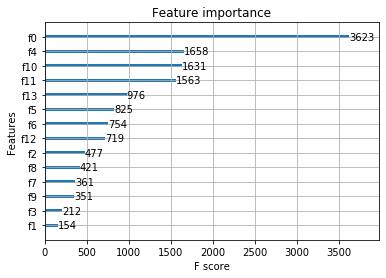

In [56]:
xgb.plot_importance(bst)

Standarad Scale features as a sanity check, but then again many of our features are already between 0-1 due to sin / cos transformations, one-hot encoding, and such.

In [57]:
#scaling
copy_train = StandardScaler().fit_transform(X3_train)
copy_test = StandardScaler().fit_transform(X3_test)
dtrain = xgb.DMatrix(copy_train, label=y3_train)
bst = xgb.train(param, dtrain, num_round)
dtest = xgb.DMatrix(copy_test)
pred_xgb = bst.predict(dtest)
print(mean_absolute_percentage_error(y3_test, pred_xgb))

8.375243494968867


## Support Vector Machines

Surprisingly bad results, could probably achieve better performance with some hyperparemeter tuning. 

In [58]:
svm_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('linear_svr', LinearSVR(C=1))
])
svm_clf.fit(X3_train, y3_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linear_svr',
                 LinearSVR(C=1, dual=True, epsilon=0.0, fit_intercept=True,
                           intercept_scaling=1.0, loss='epsilon_insensitive',
                           max_iter=1000, random_state=None, tol=0.0001,
                           verbose=0))],
         verbose=False)

In [59]:
pred_svm = svm_clf.predict(X3_test)
print(mean_absolute_percentage_error(y3_test, pred_svm))
print(svm_clf.score(X3_test, y3_test))

98.81627834221325
-10.439513722546375


Changing the kernel provides a dramatically better model but still nowhere near our linear regression baseline

In [60]:
svm_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVR(kernel='poly', degree=3, coef0=1, C=5, verbose=True))
])
svm_clf.fit(X3_train, y3_train)
pred_svm = svm_clf.predict(X3_test)
print(mean_absolute_percentage_error(y3_test, pred_svm))

[LibSVM]32.16209283670682


In [61]:
svm_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVR(kernel='rbf', gamma=5, C=0.001, verbose=True))
])
svm_clf.fit(X3_train, y3_train)
pred_svm = svm_clf.predict(X3_test)
print(mean_absolute_percentage_error(y3_test, pred_svm))

[LibSVM]34.410290959794345


# Going Further

We add in our word embeddings as features 

In [62]:
X3 = np.array(training_df[['Followers at Posting', 'Album', 'Video', 'Photo', 'Mentions', 'Hashtags', 'dow_sin',
                          'dow_cos', 'mnth_cos', 'mnth_sin', 'hr_sin', 'hr_cos', 'day_cos', 'day_sin', 'Year']])
y3 = np.array(training_df['Engagements'])

X = np.hstack((vecs_sppmi, X3))

X6_train, X6_test, y6_train, y6_test = train_test_split(X, y3, test_size=0.2)

## Hyeropt

This section was run on Google Collab. The resulting best parameters are found in 5.2.

In [63]:
SEED = 314159265
VALID_SIZE = 0.2
TARGET = 'outcome'

def score(params):
    print("Training with params: ")
    print(params)
    num_round = int(params['n_estimators'])
    del params['n_estimators']
    dtrain = xgb.DMatrix(train_features, label=y_train)
    dvalid = xgb.DMatrix(valid_features, label=y_valid)
    watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
    gbm_model = xgb.train(params, dtrain, num_round,
                          evals=watchlist,
                          verbose_eval=True)
    predictions = gbm_model.predict(dvalid,
                                    ntree_limit=gbm_model.best_iteration + 1)
    score = mean_absolute_percentage_error(y_valid, predictions)
    # TODO: Add the importance for the selected features
    print("\tScore {0}\n\n".format(score))
    # The score function should return the loss (1-score)
    # since the optimize function looks for the minimum
    loss = score
    return {'loss': loss, 'status': STATUS_OK}


def optimize(
             #trials, 
             random_state=SEED):
    """
    This is the optimization function that given a space (space here) of 
    hyperparameters and a scoring function (score here), finds the best hyperparameters.
    """
    # To learn more about XGBoost parameters, head to this page: 
    # https://github.com/dmlc/xgboost/blob/master/doc/parameter.md
    space = {
        'n_estimators': hp.quniform('n_estimators', 100, 1000, 1),
        'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
        # A problem with max_depth casted to float instead of int with
        # the hp.quniform method.
        'max_depth':  hp.choice('max_depth', np.arange(1, 14, dtype=int)),
        'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
        'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
        'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
        'eval_metric': 'mae',
        'silent': 1,
        'seed': random_state
    }
    # Use the fmin function from Hyperopt to find the best hyperparameters
    best = fmin(score, space, algo=tpe.suggest, 
                # trials=trials, 
                max_evals=250)
    return best

In [64]:
train_features = X6_train
valid_features = X6_test
y_train = y6_train
y_valid = y6_test

In [66]:
best_hyperparams = optimize(
                            #trials
                            )
print("The best hyperparameters are: ", "\n")
print(best_hyperparams)

## BEST MODEL SO FAR

In [67]:
param = {'eta': 0.07500000000000001, 
         'gamma': 0.5,
         'max_depth': 7, 
         'min_child_weight': 5.0, 
         'n_estimators': 740.0,
         'seed': 314159265,
         'subsample': 0.9500000000000001}
num_round = int(param['n_estimators'])

dtrain = xgb.DMatrix(X6_train, label=y6_train)
bst = xgb.train(param, dtrain, num_round)

dtest = xgb.DMatrix(X6_test)
pred_combo = bst.predict(dtest)
print(mean_absolute_percentage_error(y6_test, pred_combo))

3.0889571625407153


## PCA on SPPMI Matrix
Having the number of features we do seems counterproductive to generalization so let us see if PCA is helpful

In [68]:
pca = PCA(n_components=500)
copy = vecs_sppmi.copy()
vecs_reduced_sppmi = pca.fit_transform(copy)

In [69]:
X3 = np.array(training_df[['Followers at Posting', 'Album', 'Video', 'Photo', 'Mentions', 'Hashtags', 'dow_sin',
                          'dow_cos', 'mnth_cos', 'mnth_sin', 'hr_sin', 'hr_cos', 'day_cos', 'day_sin', 'Year']])
y3 = np.array(training_df['Engagements'])

X = np.hstack((vecs_reduced_sppmi, X3))

X7_train, X7_test, y7_train, y7_test = train_test_split(X, y3, test_size=0.2)

dtrain = xgb.DMatrix(X7_train, label=y7_train)
bst = xgb.train(param, dtrain, num_round)

dtest = xgb.DMatrix(X7_test)
pred_combo = bst.predict(dtest)
print(mean_absolute_percentage_error(y7_test, pred_combo))

4.5994501863011825


## Generating Submission Predictions 

We retrain our model on all of the data instead of splitting for a validation set 

In [70]:
X = np.array(training_df[['Followers at Posting', 'Album', 'Video', 'Photo', 'Mentions', 'Hashtags', 'dow_sin',
                          'dow_cos', 'mnth_cos', 'mnth_sin', 'hr_sin', 'hr_cos', 'day_cos', 'day_sin', 'Year']])
y = np.array(training_df['Engagements'])

X_train = np.hstack((X, vecs_sppmi))

In [71]:
xh = np.array(holdout_df[['Followers at Posting', 'Album', 'Video', 'Photo', 'Mentions', 'Hashtags', 'dow_sin',
                          'dow_cos', 'mnth_cos', 'mnth_sin', 'hr_sin', 'hr_cos', 'day_cos', 'day_sin', 'Year']])
X_holdout = np.hstack((xh, vecs_holdout_sppmi))

In [72]:
dtrain = xgb.DMatrix(X_train, label=y)
bst = xgb.train(param, dtrain, num_round)

In [75]:
holdout = xgb.DMatrix(X_holdout)
pred = bst.predict(holdout)

In [76]:
holdout_df['Engagements'] = pred

In [ ]:
holdout_df.to_csv('holdout_set_bioballers.csv')

Sanity Check: Assuming the data generation process for the holdout and training are the same, the distribution of our predictions should be relatively similar to the distribution of engagements in the traing set. We see this. 

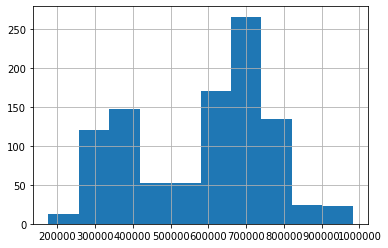

In [77]:
holdout_df['Engagements'].hist()

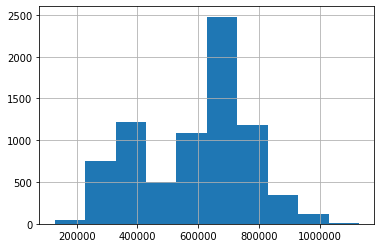

In [74]:
training_df['Engagements'].hist()